# Assignment 3C: Denoising Diffusion Probabilistic Models (DDPM)

In this assignment, you will implement a simplified version of the **Denoising Diffusion Probabilistic Model (DDPM)**, one of the foundational generative models behind modern AI image generators like Stable Diffusion and DALL-E.

Diffusion models work by:
1. **Forward Process**: Gradually adding Gaussian noise to data until it becomes pure noise
2. **Reverse Process**: Learning to denoise, step by step, to generate new samples from random noise

By the end of this lab, you will be able to generate handwritten digits from scratch using your own diffusion model!

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import math

In [2]:
# I kept getting an error about runtime, so I added this in to bypass
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Configuration

Below we define the hyperparameters for our diffusion model. Feel free to experiment with these values, except those marked as `DO NOT MODIFY`.

In [106]:
class Config:
    # Training parameters
    batch_size: int = 128
    learning_rate: float = 2e-4
    num_epochs: int = 10
    
    # Diffusion parameters
    num_timesteps: int = 1000  # Number of diffusion steps (T)
    beta_start: float = 1e-4  # Starting noise level
    beta_end: float = 0.02    # Ending noise level
    
    # Model parameters
    image_size: int = 28      # MNIST image size (DO NOT MODIFY)
    in_channels: int = 1      # MNIST is grayscale (DO NOT MODIFY)
    hidden_dims: int = 64     # Hidden dimension for U-Net
    
    # Device
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    seed: int = 42

config = Config()
torch.manual_seed(config.seed)
print(f"Using device: {config.device}")

Using device: cpu


## Data Loading

We will use the MNIST dataset for this assignment. The images are normalized to the range [-1, 1].

In [4]:
# Data transformation: normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0)

print(f"Dataset size: {len(train_dataset)}")
print(f"Number of batches: {len(train_loader)}")

Dataset size: 60000
Number of batches: 469


Let's visualize some samples from the dataset:

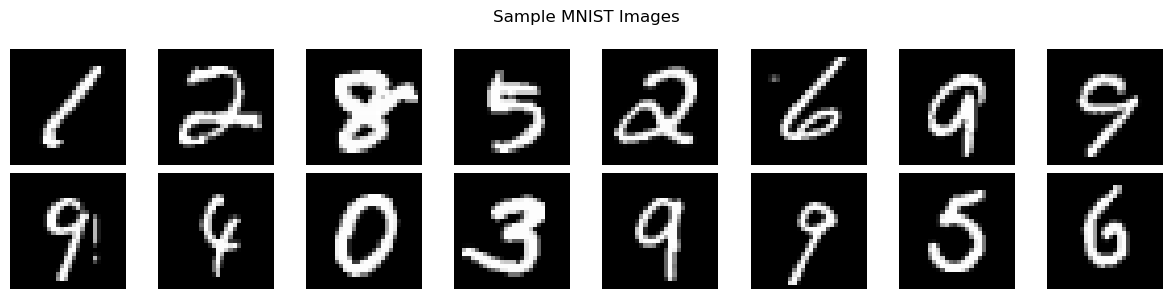

In [5]:
# Visualize some samples
sample_batch, _ = next(iter(train_loader))
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(sample_batch[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.suptitle('Sample MNIST Images')
plt.tight_layout()
plt.show()

## Part 1: Noise Scheduler

The noise scheduler defines how noise is added during the forward process. We use a linear schedule where $\beta_t$ increases linearly from `beta_start` to `beta_end`.

Key quantities:
- $\beta_t$: Noise variance at timestep $t$
- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$ (cumulative product)

The forward process is defined as:
$$q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) I)$$

This means we can sample $x_t$ directly from $x_0$:
$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)$$

### IMPLEMENTATION REQUIRED - Implement the `NoiseScheduler` class

Complete the `__init__` method to compute:
1. `betas`: Linear schedule from `beta_start` to `beta_end`
2. `alphas`: $\alpha_t = 1 - \beta_t$
3. `alpha_cumprods`: $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$
4. `sqrt_alpha_cumprods`: $\sqrt{\bar{\alpha}_t}$
5. `sqrt_one_minus_alpha_cumprods`: $\sqrt{1 - \bar{\alpha}_t}$

In [12]:
class NoiseScheduler:
    def __init__(self, num_timesteps, beta_start, beta_end, device):
        self.num_timesteps = num_timesteps
        self.device = device
        
        # YOUR CODE HERE
        # (1) Create linear schedule for betas
        # (2) Compute alphas
        # (3) Compute cumulative product of alphas
        # (4) Compute sqrt of alpha_cumprods
        # (5) Compute sqrt of (1 - alpha_cumprods)
        
        self.betas = torch.linspace(beta_start, beta_end, self.num_timesteps, device=self.device)
        
        self.alphas = 1 - self.betas
        
        self.alpha_cumprods = torch.cumprod(self.alphas, dim=0)
        
        self.sqrt_alpha_cumprods = torch.sqrt(self.alpha_cumprods)
        
        self.sqrt_one_minus_alpha_cumprods = torch.sqrt(1 - self.sqrt_alpha_cumprods)
        
    def add_noise(self, x_0, t, noise=None):
        """
        Add noise to x_0 to get x_t using the reparameterization trick.
        x_t = sqrt(alpha_cumprod_t) * x_0 + sqrt(1 - alpha_cumprod_t) * noise
        """
        if noise is None:
            noise = torch.randn_like(x_0)
        
        sqrt_alpha_cumprod_t = self.sqrt_alpha_cumprods[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alpha_cumprods[t].view(-1, 1, 1, 1)
        
        x_t = sqrt_alpha_cumprod_t * x_0 + sqrt_one_minus_alpha_cumprod_t * noise
        return x_t, noise

In [13]:
# Initialize the noise scheduler
scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    device=config.device
)

Let's visualize the forward diffusion process to understand how noise is gradually added:

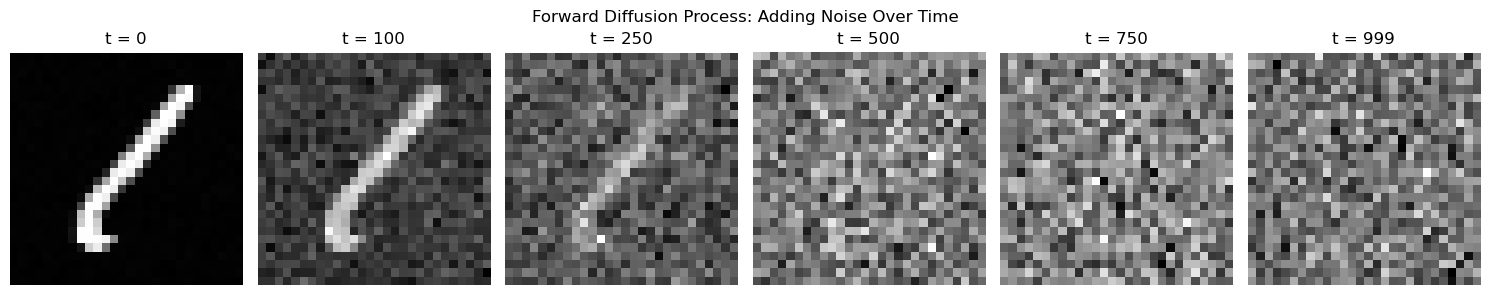

In [14]:
# Visualize the forward diffusion process
sample_image = sample_batch[0:1].to(config.device)
timesteps_to_show = [0, 100, 250, 500, 750, 999]

fig, axes = plt.subplots(1, len(timesteps_to_show), figsize=(15, 3))
for i, t in enumerate(timesteps_to_show):
    t_tensor = torch.tensor([t], device=config.device)
    noisy_image, _ = scheduler.add_noise(sample_image, t_tensor)
    axes[i].imshow(noisy_image[0].squeeze().cpu(), cmap='gray')
    axes[i].set_title(f't = {t}')
    axes[i].axis('off')
plt.suptitle('Forward Diffusion Process: Adding Noise Over Time')
plt.tight_layout()
plt.show()

## Part 2: Time Embedding

The model needs to know the current timestep to predict the noise. We use sinusoidal positional embeddings (similar to Transformers) to encode the timestep.

$$PE(t, 2i) = \sin(t / 10000^{2i/d})$$
$$PE(t, 2i+1) = \cos(t / 10000^{2i/d})$$

### IMPLEMENTATION REQUIRED - Implement `SinusoidalPositionEmbedding`

Complete the `forward` method to compute sinusoidal embeddings for the timestep.

In [88]:
class SinusoidalPositionEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        """
        Create sinusoidal position embeddings for timestep t.
        Args:
            t: Tensor of shape (batch_size,) containing timesteps
        Returns:
            Tensor of shape (batch_size, dim) containing embeddings
        """
        device = t.device
        half_dim = self.dim // 2
        
        # YOUR CODE HERE
        # (1) Compute the frequency divisor term
        # (2) Compute position * frequency
        # (3) Apply sin and cos, then concatenate
        
        div = torch.exp(torch.arange(0, half_dim, device=device) * math.log(10000.0) /half_dim)
        
        posf = t[:,None] * div[None,:]
        
        embeddings = torch.cat([torch.sin(posf), torch.cos(posf)], dim=-1)
        return embeddings

## Part 3: U-Net Architecture

The U-Net is the backbone of our diffusion model. It takes a noisy image and the timestep embedding, and predicts the noise that was added.

The architecture consists of:
1. **Encoder**: Downsamples the image while increasing channels
2. **Middle Block**: Processes the compressed representation
3. **Decoder**: Upsamples back to the original resolution with skip connections

We'll implement a simplified version suitable for MNIST.

In [89]:
class ConvBlock(nn.Module):
    """Convolutional block with GroupNorm and SiLU activation."""
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.norm2 = nn.GroupNorm(8, out_channels)
        self.act = nn.SiLU()
        
        # Time embedding projection
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        
        # Residual connection if channels don't match
        self.residual_conv = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
    
    def forward(self, x, t_emb):
        h = self.act(self.norm1(self.conv1(x)))
        
        # Add time embedding
        time_emb = self.act(self.time_mlp(t_emb))
        h = h + time_emb[:, :, None, None]
        
        h = self.act(self.norm2(self.conv2(h)))
        return h + self.residual_conv(x)

### IMPLEMENTATION REQUIRED - Implement the U-Net `forward` method

Complete the forward pass of the U-Net:
1. Get time embeddings
2. Encoder: Apply conv blocks and downsample, saving skip connections
3. Middle: Apply middle block
4. Decoder: Upsample, concatenate skip connections, and apply conv blocks
5. Output: Project to the number of output channels

In [98]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, hidden_dims=64, time_emb_dim=128):
        super().__init__()
        
        # Time embedding
        self.time_embedding = nn.Sequential(
            SinusoidalPositionEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        
        # Initial convolution
        self.init_conv = nn.Conv2d(in_channels, hidden_dims, kernel_size=3, padding=1)
        
        # Encoder (downsampling path)
        self.down1 = ConvBlock(hidden_dims, hidden_dims, time_emb_dim)
        self.down2 = ConvBlock(hidden_dims, hidden_dims * 2, time_emb_dim)
        self.pool = nn.MaxPool2d(2)
        
        # Middle
        self.middle = ConvBlock(hidden_dims * 2, hidden_dims * 2, time_emb_dim)
        
        # Decoder (upsampling path)
        self.up1 = ConvBlock(hidden_dims * 4, hidden_dims, time_emb_dim)  # *4 because of skip connection
        self.up2 = ConvBlock(hidden_dims * 2, hidden_dims, time_emb_dim)  # *2 because of skip connection
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        
        # Output
        self.final_conv = nn.Conv2d(hidden_dims, out_channels, kernel_size=1)
    
    def forward(self, x, t):
        """
        Forward pass of the U-Net.
        Args:
            x: Noisy image tensor of shape (batch_size, channels, height, width)
            t: Timestep tensor of shape (batch_size,)
        Returns:
            Predicted noise tensor of same shape as x
        """
        # YOUR CODE HERE
        # (1) Get time embeddings
        # (2) Initial convolution
        # (3) Encoder path: down1 -> pool -> down2 -> pool (save skip connections)
        # (4) Middle block
        # (5) Decoder path: upsample -> concat skip2 -> up1 -> upsample -> concat skip1 -> up2
        # (6) Final convolution
        time = self.time_embedding(t)
 
        x = self.init_conv(x)
        
        skip1 = self.down1(x, time)
        x = self.pool(skip1)
        skip2 = self.down2(x, time)
        x = self.pool(skip2)
        
        x = self.middle(x, time)
        
        x = self.upsample(x)
        x = torch.cat([x, skip2], dim=1)
        x = self.up1(x, time)
        x = self.upsample(x)
        x = torch.cat([x, skip1], dim=1)
        x = self.up2(x, time)
        
        x = self.final_conv(x)
        
        return x

In [99]:
# Initialize the model
model = SimpleUNet(
    in_channels=config.in_channels,
    out_channels=config.in_channels,
    hidden_dims=config.hidden_dims
).to(config.device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 1,011,969


## Part 4: Training

The training objective is simple: predict the noise that was added to the image.

$$\mathcal{L} = \mathbb{E}_{t, x_0, \epsilon}\left[\|\epsilon - \epsilon_\theta(x_t, t)\|^2\right]$$

Where:
- $\epsilon$ is the actual noise added
- $\epsilon_\theta(x_t, t)$ is the model's prediction

### IMPLEMENTATION REQUIRED - Implement the training loop

Complete the training loop:
1. Sample random timesteps
2. Add noise to the images using the scheduler
3. Predict the noise using the model
4. Compute MSE loss between predicted and actual noise

In [100]:
def train_one_epoch(model, dataloader, optimizer, scheduler, config):
    model.train()
    total_loss = 0
    
    for images, _ in tqdm(dataloader, desc="Training"):
        images = images.to(config.device)
        batch_size = images.shape[0]
        
        # YOUR CODE HERE
        # (1) Sample random timesteps
        # (2) Add noise to images
        # (3) Predict noise
        # (4) Compute MSE loss
        
        t = torch.randint(0, config.num_timesteps, (batch_size,), device=config.device)
        
        noisy_images, noise = scheduler.add_noise(images, t)
        
        predicted_noise = model(noisy_images, t)
        
        loss = F.mse_loss(predicted_noise, noise)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [101]:
# Training setup
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

# Training loop
losses = []
for epoch in range(config.num_epochs):
    avg_loss = train_one_epoch(model, train_loader, optimizer, scheduler, config)
    losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{config.num_epochs}, Loss: {avg_loss:.4f}")

Training: 100%|██████████████████████████| 469/469 [22:40<00:00,  2.90s/it]


Epoch 1/10, Loss: 0.0950


Training: 100%|██████████████████████████| 469/469 [26:38<00:00,  3.41s/it]


Epoch 2/10, Loss: 0.0429


Training: 100%|██████████████████████████| 469/469 [38:52<00:00,  4.97s/it]


Epoch 3/10, Loss: 0.0377


Training: 100%|██████████████████████████| 469/469 [21:51<00:00,  2.80s/it]


Epoch 4/10, Loss: 0.0351


Training: 100%|██████████████████████████| 469/469 [20:22<00:00,  2.61s/it]


Epoch 5/10, Loss: 0.0334


Training: 100%|██████████████████████████| 469/469 [20:02<00:00,  2.56s/it]


Epoch 6/10, Loss: 0.0325


Training: 100%|██████████████████████████| 469/469 [20:23<00:00,  2.61s/it]


Epoch 7/10, Loss: 0.0319


Training: 100%|██████████████████████████| 469/469 [22:22<00:00,  2.86s/it]


Epoch 8/10, Loss: 0.0310


Training: 100%|██████████████████████████| 469/469 [19:48<00:00,  2.53s/it]


Epoch 9/10, Loss: 0.0301


Training: 100%|██████████████████████████| 469/469 [21:25<00:00,  2.74s/it]

Epoch 10/10, Loss: 0.0299


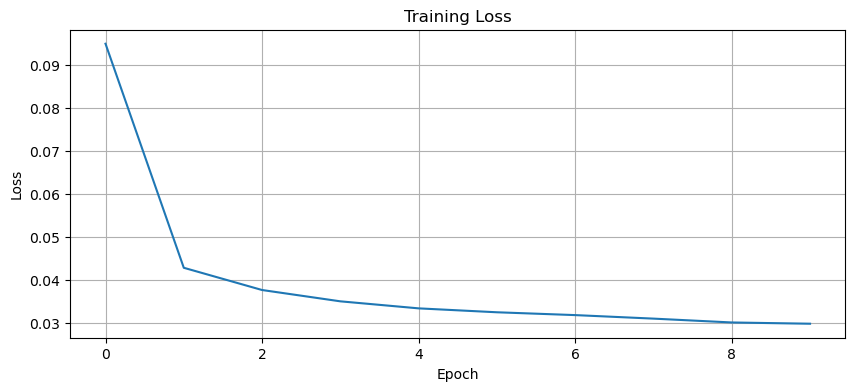

In [102]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

## Part 5: Sampling (Image Generation)

To generate images, we start from pure noise and iteratively denoise using our trained model.

The sampling process (simplified DDPM):
$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}}\left(x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}}\epsilon_\theta(x_t, t)\right) + \sigma_t z$$

Where $z \sim \mathcal{N}(0, I)$ and $\sigma_t = \sqrt{\beta_t}$

### IMPLEMENTATION REQUIRED - Implement the `sample_step` function

Complete the sampling step to denoise from $x_t$ to $x_{t-1}$.

In [114]:
@torch.no_grad()
def sample_step(model, x_t, t, scheduler):
    """
    Perform one denoising step: x_t -> x_{t-1}
    """
    # Get the values we need from the scheduler
    beta_t = scheduler.betas[t]
    alpha_t = scheduler.alphas[t]
    alpha_cumprod_t = scheduler.alpha_cumprods[t]
    sqrt_one_minus_alpha_cumprod_t = scheduler.sqrt_one_minus_alpha_cumprods[t]
    
    # YOUR CODE HERE
    # (1) Predict the noise (need to create timestep tensor for the model)
    # (2) Compute the noise coefficient
    # (3) Compute the mean of x_{t-1}
    # (4) Add noise for t > 0, otherwise just return mean
    batch_size = x_t.shape[0]
    timestep_tensor = torch.full((batch_size,), t, device=x_t.device)
    predicted_noise = model(x_t, timestep_tensor)
    
    coef = beta_t / sqrt_one_minus_alpha_cumprod_t
    
    mean = (1/torch.sqrt(alpha_t))*(x_t - coef*predicted_noise)
    
    if (t > 0):
        noise = torch.randn(mean.shape)
        x_t_minus_1 = mean + torch.sqrt(beta_t) * noise
    else:
        x_t_minus_1 = mean
    return x_t_minus_1

In [115]:
@torch.no_grad()
def sample(model, scheduler, config, num_samples=16):
    """
    Generate samples by iteratively denoising from pure noise.
    """
    model.eval()
    
    # Start from pure noise
    x = torch.randn(num_samples, config.in_channels, config.image_size, config.image_size).to(config.device)
    
    # Iteratively denoise
    for t in tqdm(range(config.num_timesteps - 1, -1, -1), desc="Sampling"):
        x = sample_step(model, x, t, scheduler)
    
    # Clamp to [-1, 1] and convert to [0, 1] for visualization
    x = torch.clamp(x, -1, 1)
    x = (x + 1) / 2
    
    return x

Sampling: 100%|████████████████████████| 1000/1000 [01:53<00:00,  8.83it/s]


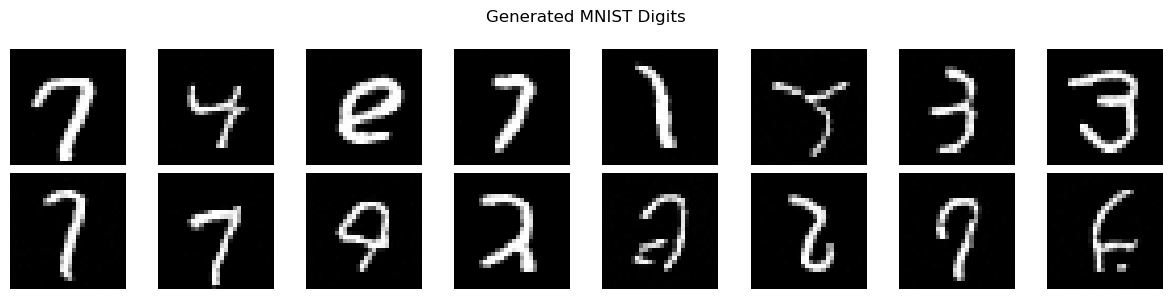

In [116]:
# Generate samples
generated_samples = sample(model, scheduler, config, num_samples=16)

# Visualize generated samples
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_samples[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.suptitle('Generated MNIST Digits')
plt.tight_layout()
plt.show()

## Part 6: Visualize the Reverse Diffusion Process

Let's visualize how the model gradually denoises to generate an image:

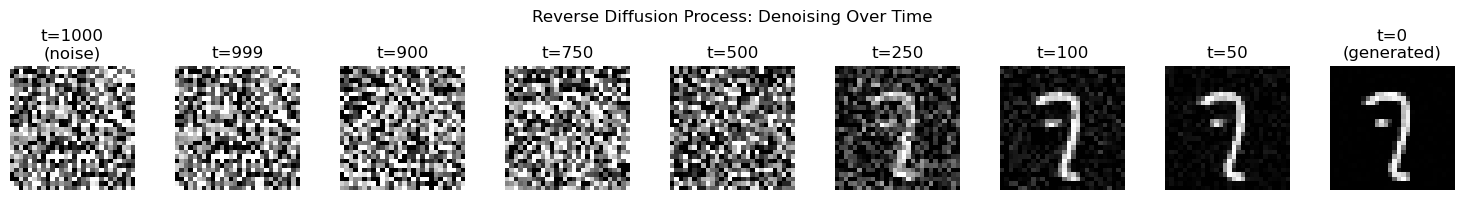

In [117]:
@torch.no_grad()
def sample_with_trajectory(model, scheduler, config):
    """Sample and save intermediate steps for visualization."""
    model.eval()
    
    x = torch.randn(1, config.in_channels, config.image_size, config.image_size).to(config.device)
    trajectory = [x.clone()]
    
    save_steps = [999, 900, 750, 500, 250, 100, 50, 0]
    
    for t in range(config.num_timesteps - 1, -1, -1):
        x = sample_step(model, x, t, scheduler)
        if t in save_steps:
            trajectory.append(x.clone())
    
    return trajectory, save_steps

trajectory, steps = sample_with_trajectory(model, scheduler, config)

fig, axes = plt.subplots(1, len(trajectory), figsize=(15, 2))
titles = ['t=1000\n(noise)'] + [f't={s}' for s in steps[:-1]] + ['t=0\n(generated)']
for i, (img, title) in enumerate(zip(trajectory, titles)):
    img = torch.clamp(img, -1, 1)
    img = (img + 1) / 2
    axes[i].imshow(img[0].squeeze().cpu(), cmap='gray')
    axes[i].set_title(title)
    axes[i].axis('off')
plt.suptitle('Reverse Diffusion Process: Denoising Over Time')
plt.tight_layout()
plt.show()

## Save the Model

In [118]:
# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'config': config
}, 'diffusion_model.pt')
print("Model saved!")

Model saved!


## Summary

In this assignment, you implemented:

1. **Noise Scheduler**: Defines how noise is added during the forward process
2. **Sinusoidal Position Embedding**: Encodes the timestep for the model
3. **U-Net Architecture**: Predicts the noise added to images
4. **Training Loop**: Optimizes the model to predict noise
5. **Sampling**: Generates new images by iteratively denoising

Congratulations! You've built a working diffusion model from scratch. This is the same fundamental approach used in state-of-the-art image generation models like Stable Diffusion, DALL-E, and Imagen.